In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append('../../')
sys.path.append('../')
from evaluate.eval_utils import get_simple_eval_metrics

OUTPUT_ROOT = "/sailhome/esui/cs224u_final_project/prontoqa_output/fictional/aggregated"

def get_metrics_dict_for_prompt_type(prompt_type, k, restrict_type='none'):

    dir = os.path.join(prompt_type, "summary")
    filename = 'merge_answer_hard_merge_cot_none_path_select_heaviest' + f"_{k}hop.pkl"
    path = os.path.join(OUTPUT_ROOT, dir, filename)

    metrics_dict = get_simple_eval_metrics(path, restrict_type=restrict_type)
    return metrics_dict

def get_data_for_all_metrics(metrics_dict, prompt_types):
    data = []
    for metric in metrics_dict[prompt_types[0]].keys():
        data_metric = [metric]
        for prompt_type in prompt_types:
            data_metric.append(metrics_dict[prompt_type][metric])
        data.append(data_metric)
    return data

def plot_metric(metrics_df, metric, title, save_file):
    metrics_df = metrics_df[metrics_df['metric'] == metric]
    metrics_df = metrics_df.drop(columns=['metric']).T

    # Rename the metrics
    mapping = {
        'avg_label_acc': "Average Label Accuracy",
        "avg_cot_acc": "Average CoT Accuracy",
        "avg_cot_precision": "Average CoT Precision",
        "avg_cot_recall": "Average CoT Recall",
        "avg_cot_f1": "Average CoT F1"
    }

    metric = mapping[metric]

    metrics_df = metrics_df.rename(columns={0:metric})
    metrics_df = metrics_df.reset_index().rename(columns={'index':'Prompting Strategy'})

    # Rename the aggregation types
    mapping = {
        'single_baseline':'Baseline', 
        'single_forward': "Forward Chaining",
        'single_backward': "Backward Chaining",
        'single_baseline_neg': "Baseline Negate All Queries",
        'single_forward_neg': "Forward Negate All Queries",
        'single_backward_neg': "Backward Negate All Queries",
        'double_baseline_negation': "Baseline Negate 'not' Queries",
        'double_forward_negation': "Forward Negate 'not' Queries",
        'double_backward_negation': "Backward Negate 'not' Queries",
    }
    metrics_df['Prompting Strategy'] = metrics_df['Prompting Strategy'].map(mapping)

    print(metrics_df)
    kind='barh'
    ax = metrics_df.plot(
        x='Prompting Strategy',
        xlabel=metric,
        kind=kind,
        stacked=False,
        title=title,
        legend=False,
    )

    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f')
    
    plt.savefig(save_file, bbox_inches='tight')

              Prompting Strategy  Average Label Accuracy
0  Backward Negate 'not' Queries                    0.95
1    Backward Negate All Queries                    0.92
2              Backward Chaining                    0.90
3   Forward Negate 'not' Queries                    0.94
4     Forward Negate All Queries                    0.94
5               Forward Chaining                    0.90
6  Baseline Negate 'not' Queries                    0.98
7    Baseline Negate All Queries                    0.95
8                       Baseline                    0.91
              Prompting Strategy  Average Label Accuracy
0  Backward Negate 'not' Queries                    0.77
1    Backward Negate All Queries                    0.65
2              Backward Chaining                    0.75
3   Forward Negate 'not' Queries                    0.97
4     Forward Negate All Queries                    0.92
5               Forward Chaining                    0.96
6  Baseline Negate 'not' Querie

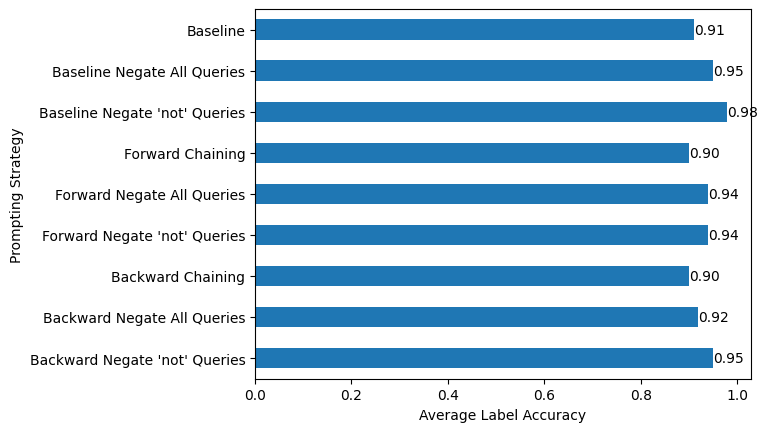

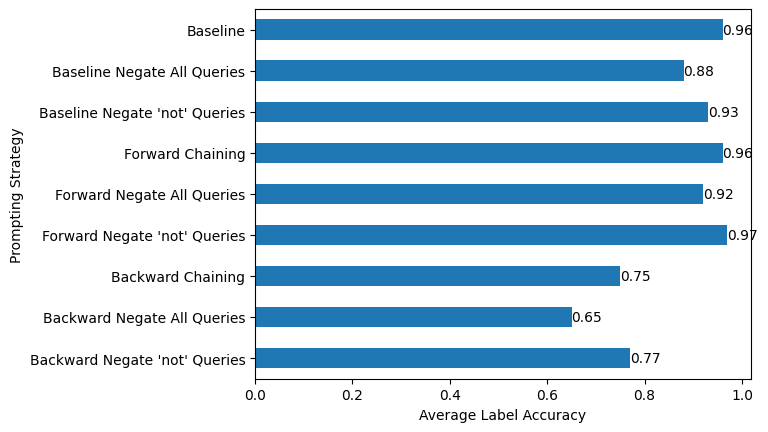

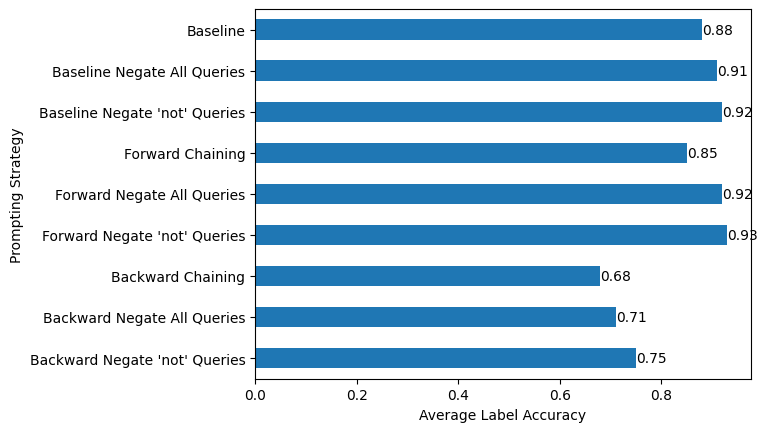

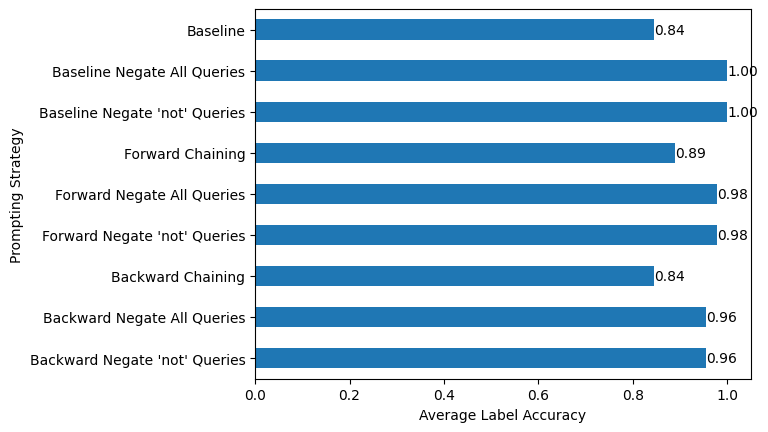

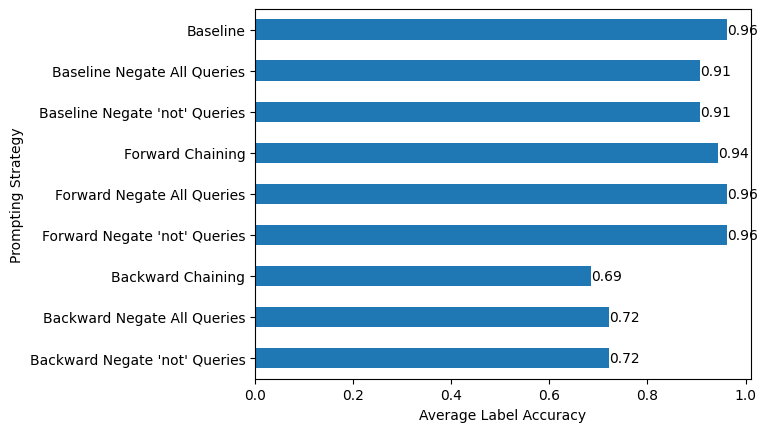

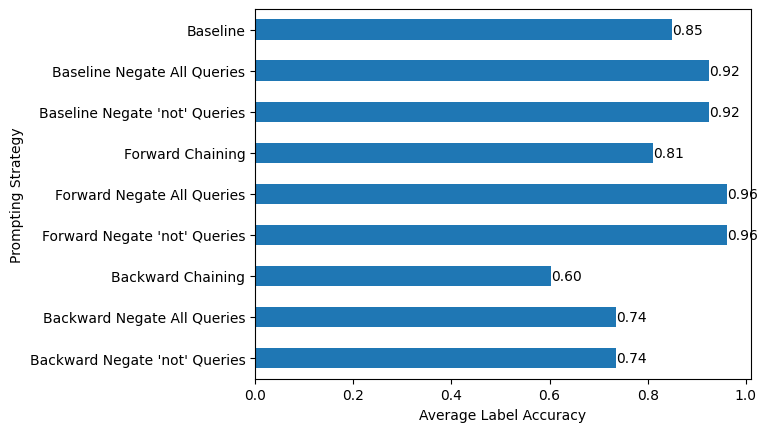

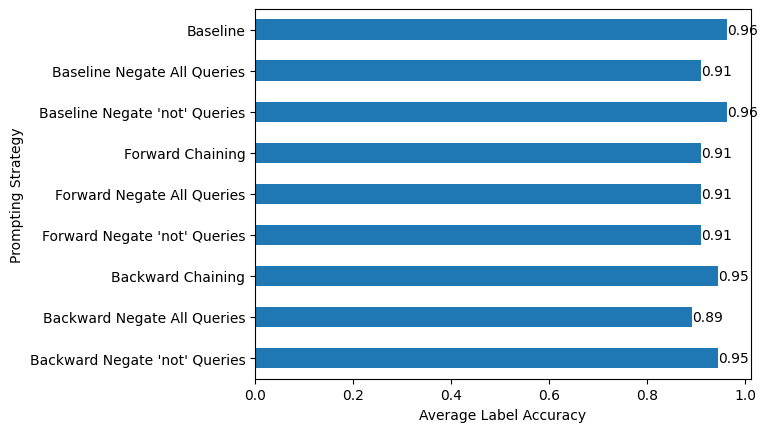

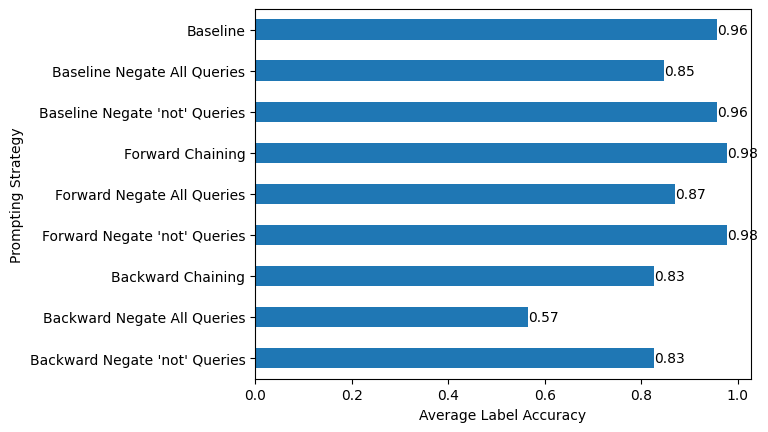

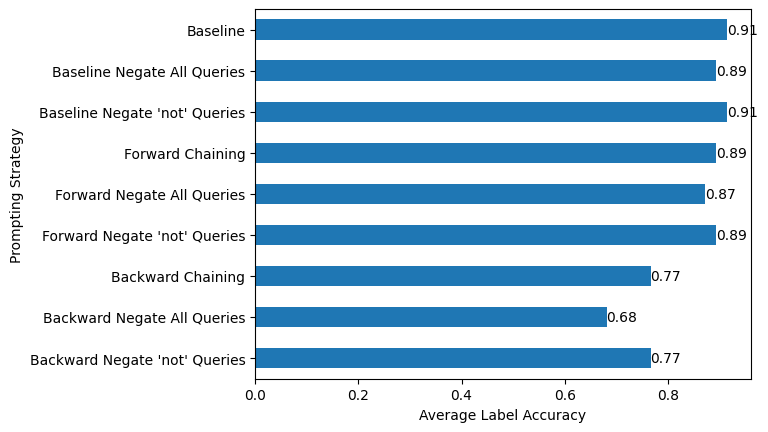

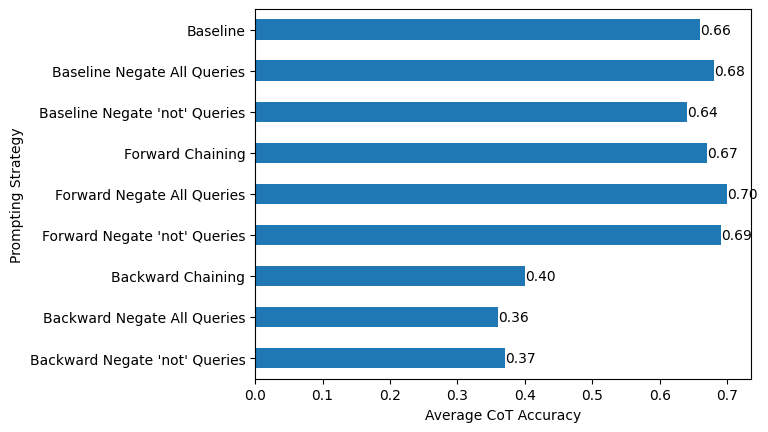

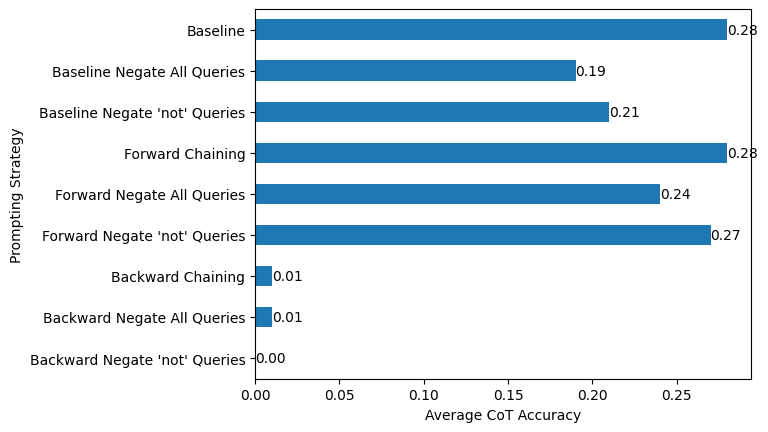

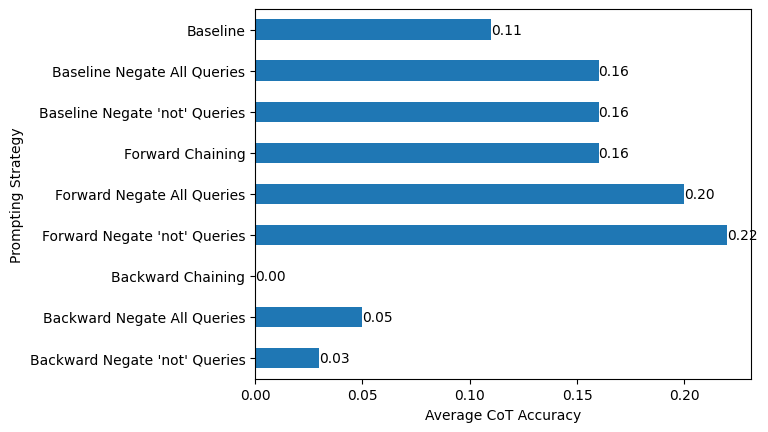

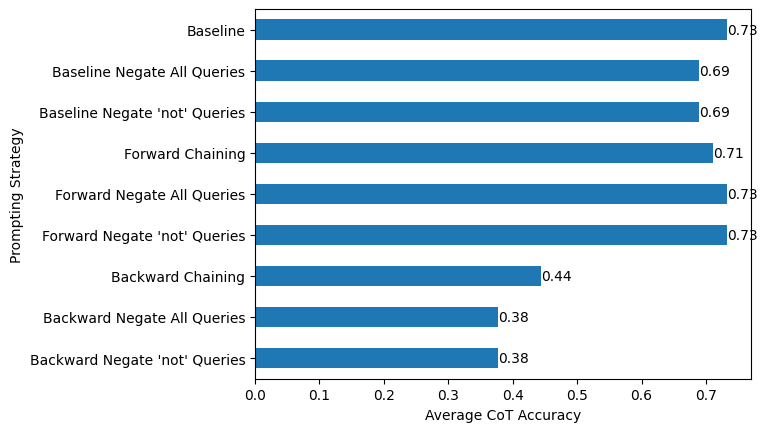

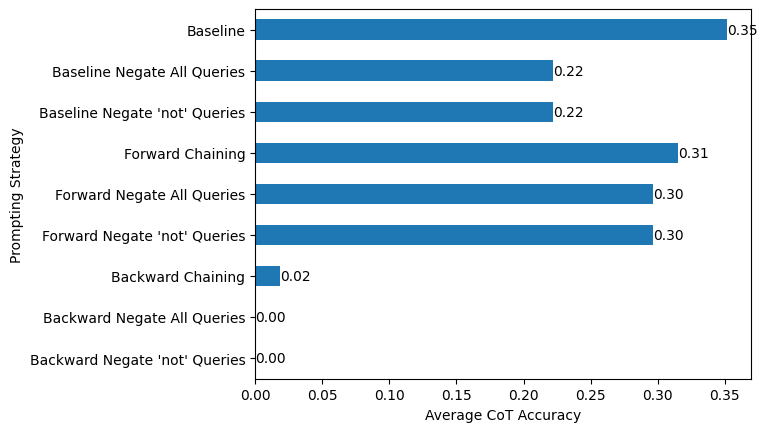

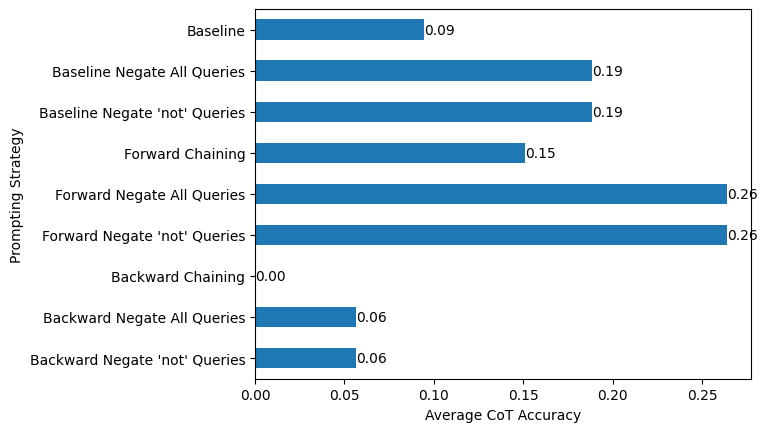

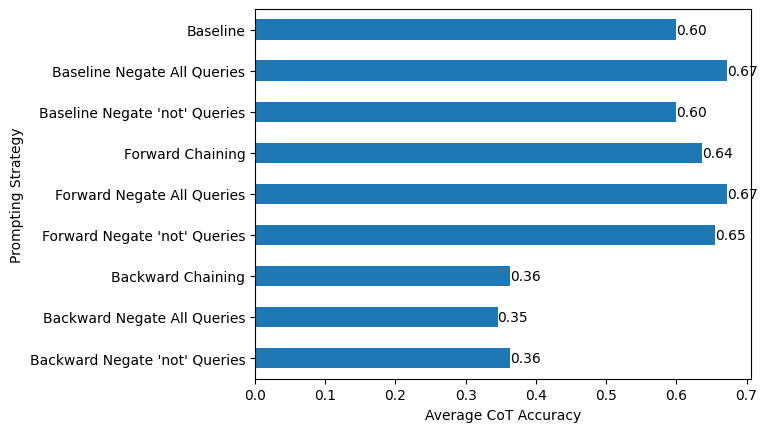

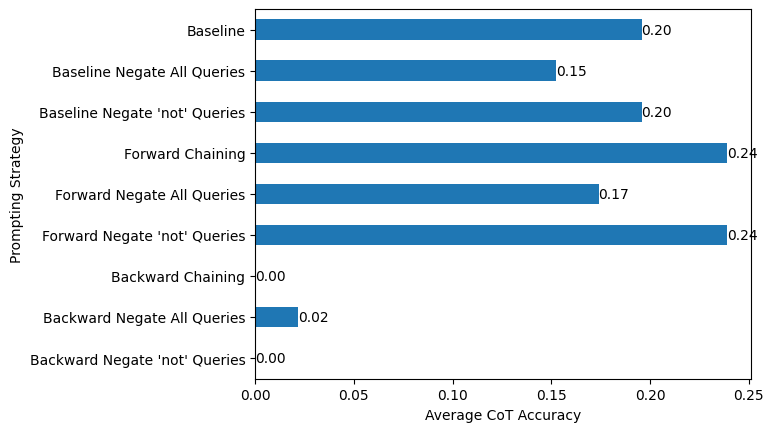

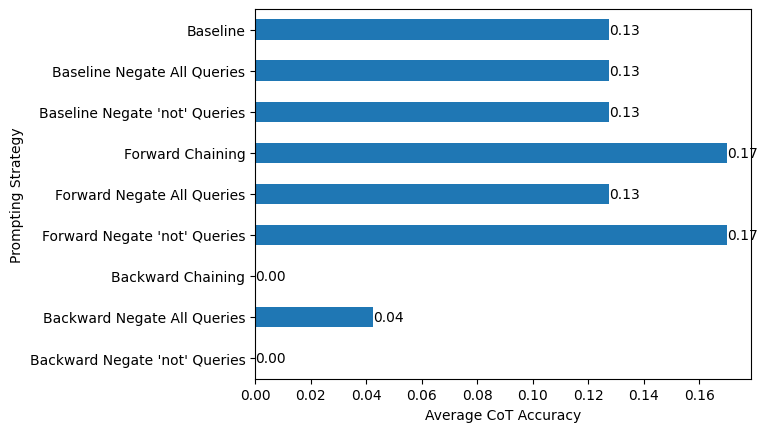

In [7]:
PROMPT_TYPES = ["single_baseline", "single_baseline_neg", "double_baseline_negation", "single_forward", "single_forward_neg", "double_forward_negation", "single_backward", "single_backward_neg", "double_backward_negation"]
PROMPT_TYPES = list(reversed(PROMPT_TYPES))
columns = ["metric"] + PROMPT_TYPES
metrics_dict = {}

for metric in ['avg_label_acc', 'avg_cot_acc']:
    for restrict_type in ['none', 'not_only', 'no_not_only']:
        if restrict_type == 'none':
            dataset_type = 'all'
        else:
            dataset_type = restrict_type

        for k in [1, 3, 5]:
            for prompt_type in PROMPT_TYPES:
                metrics_dict[prompt_type] = get_metrics_dict_for_prompt_type(prompt_type, k, restrict_type)

            data = get_data_for_all_metrics(metrics_dict, PROMPT_TYPES)

            metrics_df = pd.DataFrame(
                        columns=columns,
                        data=data,
            )

            # print(metrics_df)

            # metrics_df.plot(x='metric',
            #     kind='barh',
            #     stacked=False,
            #     title="individual eval no path selection"
            # )

            # save to csv
            dir = '/sailhome/esui/cs224u_final_project/evaluate/results/single_with_path_selection'
            os.makedirs(dir, exist_ok=True)
            metrics_df.T.to_csv(os.path.join(dir, f'{dataset_type}_path_selection_heaviest_{k}hop.csv'))

            dir = os.path.join(dir, "plots")
            os.makedirs(dir, exist_ok=True)
            plot_metric(metrics_df, metric, title=None, save_file=os.path.join(dir, f'{metric}_{dataset_type}_path_selection_heaviest_{k}hop.pdf'))